In [352]:
import joblib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
sb.set_style(rc={"pdf.fonttype": 42})
import pandas as pd
from truvari.phab import fasta_reader
import random
import re
import numpy as np
import json

In [59]:
haps = joblib.load("haps.jl")
patho = pd.read_csv("/Users/english/code/adotto/pathogenic/Patho.tsv", sep='\t').set_index("Locus")

In [63]:
bench = (pd.read_csv("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/GIABTR.HG002.benchmark.regions.bed.gz", 
                    sep='\t', names=['chrom', 'start', 'end', 'tier', 'repl', 'vflag', 'entropy', 'mad', 'pad'])
         .set_index(['chrom', 'start', 'end']))

In [14]:
meta = pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.2.bed", sep='\t')
meta = meta[(meta['patho'] != '.') | (meta['codis'] != '.')].copy().set_index(['chr', 'start', 'end'])
meta.head()

ovl_flag  up_buff  dn_buff  hom_pct  n_filtered  \
chr  start    end                                                         
chr1 7829857  7830154          6       16       25        0           0   
     8358549  8358631          4       22        0        0           3   
     39412932 39414162        15        6        0        0           8   
     57367018 57367149         1       25       25        0           0   
     62209897 62210109         6       25       25        0           4   

                        n_annos  n_subregions  mu_purity  pct_annotated  \
chr  start    end                                                         
chr1 7829857  7830154         5             1         94            100   
     8358549  8358631         1             1         87            100   
     39412932 39414162        6             4         90             73   
     57367018 57367149        1             1         98            100   
     62209897 62210109        4             1         88            100   

                       interspersed  patho codis  gene_flag         biotype  \
chr  start    end                                                             
chr1 7829857  7830154             .   PER3     .         25  protein_coding   
     8358549  8358631             .   RERE     .         25  protein_coding   
     39412932 39414162            .  MACF1     .         25  protein_coding   
     57367018 57367149            .   DAB1     .          1  protein_coding   
     62209897 62210109            .  L1TD1     .         25  protein_coding   

                                                                    annos  
chr  start    end                                                          
chr1 7829857  7830154   [{"chrom": "chr1", "start": 7829873, "end": 78...  
     8358549  8358631   [{"chrom": "chr1", "start": 8358571, "end": 83...  
     39412932 39414162  [{"chrom": "chr1", "start": 39412938, "end": 3...  
     57367018 57367149  [{"chrom": "chr1", "start": 57367043, "end": 5...  
     62209897 62210109  [{"chrom": "chr1", "start": 62209922, "end": 6...

In [211]:
def transform(d):
    """
    Taking a single locus
    """
    x = [_ for _ in fasta_reader(d.decode(), False)]
    ret = {}
    chrom, start, end, tier = None, None, None, None
    for key, seq in x:
        seq = seq.decode().strip()
        samp, hap, extra = key.split('_')
        chrom, start, end = re.split(':|-', extra)
        lkup = (chrom, int(start), int(end))
        locus = meta.loc[lkup]
        try:
            tier = bench.loc[lkup]['tier']
        except Exception: 
            pass
        ret[samp + '_' + hap] = seq

    locus_name, locus_type, motif_length = None, None, None
    if locus['codis'] != '.':
        locus_name = locus['codis']
        locus_type = "CODIS"
        motif_length = None
        # Search the max motif length
    else:
        locus_name = locus['patho']
        locus_type = "Patho"
        try:
            ml = patho.loc[locus_name]['Motifs 1']
            motif_length = len(ml) if isinstance(ml, str) else None 
        except Exception:
            motif_length = None

    locus_type = 'CODIS' if locus['codis'] != '.' else "Patho"
    if locus_name in patho.index:
        if patho.loc[locus_name]['Repeat type'] == 'VNTR':
            locus_type = "Pheno"
        else:
            locus_type = "Patho"
    return locus_name, ret, chrom, start, end, tier, locus_type, motif_length

In [330]:
rows = []
for l in haps.keys():
    test = transform(haps[l])

    hap_names = list(test[1].keys())
    locus, chrom, start, end, tier, locus_type, motiflen = test[0], test[2], test[3], test[4], test[5], test[6], test[7]

    for k in hap_names:
        rows.append([locus, chrom, start, end, k, len(test[1][k]), tier, locus_type, motiflen])
    cols = ['locus', 'chrom', 'start', 'end', 'hap', 'length', 'tier', 'type', 'motif_length']
data = pd.DataFrame(rows, columns=cols)

# I need reference length in the data so I can calculate the delta
rows = []
x = {x:len(y.strip()) for x,y in fasta_reader(open('refhaps.fa').read())}
for k,v in x.items():
    chrom, start, end = re.split(':|-', k)
    rows.append([chrom, start, end, v])
locus_lengths = pd.DataFrame(rows, columns=['chrom', 'start', 'end', 'ref_len']).set_index(['chrom', 'start', 'end'])

data['span'] = data['end'].astype(int) - data['start'].astype(int)
data = data.set_index(['chrom', 'start', 'end'])

data['ref_length'] = locus_lengths['ref_len']
data['delta'] = data['length'] - data['span']
data['is_HG002'] = data['hap'].str.startswith('HG002_')

data['appx copy'] = data['delta'] / data['motif_length']

In [331]:
data.head()

locus        hap  length   tier   type  motif_length  \
chrom start   end                                                            
chr1  7829857 7830154  PER3    HG002_1     298  Tier1  Pheno          54.0   
              7830154  PER3    HG002_2     298  Tier1  Pheno          54.0   
              7830154  PER3    HG005_1     244  Tier1  Pheno          54.0   
              7830154  PER3    HG005_2     244  Tier1  Pheno          54.0   
              7830154  PER3  HG00096_1     244  Tier1  Pheno          54.0   

                       span  ref_length  delta  is_HG002  appx copy  
chrom start   end                                                    
chr1  7829857 7830154   297         320      1      True   0.018519  
              7830154   297         320      1      True   0.018519  
              7830154   297         320    -53     False  -0.981481  
              7830154   297         320    -53     False  -0.981481  
              7830154   297         320    -53     False  -0.981481

In [149]:
data['locus'].unique()

array(['PER3', 'RERE', 'MACF1', 'DAB1', 'L1TD1', 'AL359762.1', 'OVGP1',
       'NOTCH2NLA', 'NOTCH2NLC', 'TCHH', 'HRNR', 'FLG', 'FLG2', 'LCE1E',
       'LCE1C', 'IVL', 'SPRR3', 'MUC1', 'DCAF8', 'AXDND1', 'IGFN1',
       'D1S1656', 'FMN2', 'NUTM2B-AS1', 'FRA10AC1', 'PDZD7', 'D10S1248',
       'DRD4', 'MUC5B', 'KRTAP5-1', 'KRTAP5-5', 'TH01', 'C11ORF80',
       'KRTAP5-8', 'CBL', 'vWA', 'ATN1', 'PEX5', 'NANOG', 'AC006518.7',
       'PRH2', 'PRB2', 'D12S391', 'DUSP16', 'DIP2B', 'KRT2', 'KRT1',
       'NACA', 'SELPLG', 'PHETA1', 'ATXN2', 'UBC', 'ERICH6B', 'ATXN8',
       'D13S317', 'ZIC2', 'FGF14', 'PABPN1', 'FSCB', 'ATXN3', 'AHNAK2',
       'NIPA1', 'AVEN', 'PHGR1', 'ACAN', 'PentaE', 'XYLT1', 'TNRC6A',
       'BEAN1', 'THAP11', 'ZNF19', 'D16S539', 'JPH3', 'C17orf97', 'KRT10',
       'KRTAP1-4', 'KRTAP2-1', 'KRTAP4-12', 'KRTAP4-3', 'AKAP1', 'CCDC40',
       'EIF4A3', 'TCF4', 'D18S51', 'PLIN4', 'CLEC4M', 'AC010336.3',
       'CACNA1A', 'GIPC1', 'UNC13A', 'COMP', 'ZNF737', 'ZNF626',
       'D

In [224]:
data[data['locus'] == 'FMR1']

locus           hap  length   tier   type  \
chrom start     end                                                   
chrX  147911953 147912539  FMR1       HG002_1     620  Tier2  Patho   
                147912539  FMR1       HG002_2     587  Tier2  Patho   
                147912539  FMR1       HG005_1     587  Tier2  Patho   
                147912539  FMR1       HG005_2     614  Tier2  Patho   
                147912539  FMR1     HG00096_1     614  Tier2  Patho   
...                         ...           ...     ...    ...    ...   
                147912539  FMR1  li:HG00733_2     617  Tier2  Patho   
                147912539  FMR1  li:NA12878_1     620  Tier2  Patho   
                147912539  FMR1  li:NA12878_2     620  Tier2  Patho   
                147912539  FMR1  li:NA24385_1     620  Tier2  Patho   
                147912539  FMR1  li:NA24385_2     620  Tier2  Patho   

                           motif_length  ref_length  delta  is_HG002  
chrom start     end                                                   
chrX  147911953 147912539           3.0         613     -7      True  
                147912539           3.0         613     26      True  
                147912539           3.0         613     26     False  
                147912539           3.0         613     -1     False  
                147912539           3.0         613     -1     False  
...                                 ...         ...    ...       ...  
                147912539           3.0         613     -4     False  
                147912539           3.0         613     -7     False  
                147912539           3.0         613     -7     False  
                147912539           3.0         613     -7     False  
                147912539           3.0         613     -7     False  

[172 rows x 9 columns]

In [254]:
whatisthey = ["ACAN", # std <200 top N
                #"FGF14", Has a huge deletion
                #"TRIOBP", didn't like it
                "UVSSA",
                "PRDM9",
                "SBSN",
                "FMN2",
                "KRTAP4-3",
                "DRD4",
                "MUC21",
                "CLEC4M"]
patho.loc[whatisthey]['Repeat type']

Locus
ACAN        VNTR
UVSSA       VNTR
PRDM9       VNTR
ZNF713       NaN
SBSN        VNTR
FMN2        VNTR
KRTAP4-3    VNTR
DRD4        VNTR
MUC21       VNTR
CLEC4M      VNTR
Name: Repeat type, dtype: object

In [383]:
pheno_loci = [ # Phenos
                "ACAN",
                "UVSSA",
                "PRDM9",
                "SBSN",
                "FMN2",
                "KRTAP4-3",
                "DRD4",
                "MUC21",
                "CLEC4M",
]
codis_loci = [# CODIS
               "PentaE",
                "SE33",
                "D6S1043",
            "D1S1656",
]
patho_loci =sorted([#Pathos
               "AFF3",
    #"AR", X
    #"DMD",
    "EIF4A3",
               "ATN1",
               "ATXN3",
               "NOP56",
    "JPH3",
    "C9ORF72",
               #"AFF2", X
               #"FMR1", X
                "TCF4",
    "CBL",
    #"TNRC6A", maybe
              ])




In [368]:
patho[~patho.index.isin(patho_loci) & (patho['Repeat type'] != 'VNTR')].head(30)

,chrom,start,end,Motifs 1,Motifs 2,Repeat type,Region,Path. repeats,Inheritance mode,Disease
Locus,,,,,,,,,,
VWA1,chr1,1435798,1435818,NaN,GGCGCGGAGC,NaN,Coding,>=3,Autosomal recessive,Hereditary motor neuropathy
DAB1,chr1,57367043,57367119,ATTTC,"AAAAT,GAAAT,AAAAT",Nested,Intron,>=31,Autosomal dominant,Spinocerebellar ataxia 37 (SCA37)
NOTCH2NLA,chr1,146228800,146228822,NaN,GGC,NaN,NaN,NaN,NaN,NaN
NOTCH2NLC,chr1,149390802,149390841,GGC,GGC,Standard,5' UTR,">=90,>=60",Autosomal dominant,Neuronal intranuclear inclusion disease (NIID)...
NUTM2B-AS1,chr10,79826383,79826404,CGG,CGG,Standard,Noncoding transcript,>=700,Autosomal dominant,Oculopharyngeal myopathy with leukoencephalopa...
FRA10AC1,chr10,93702522,93702547,NaN,CCG,NaN,5' UTR,NaN,NaN,NaN
C11ORF80,chr11,66744821,66744850,NaN,GCG,NaN,NaN,NaN,NaN,NaN
CBL,chr11,119206289,119206322,CCG,CGG,Standard,5' UTR,>=101,NaN,Jacobsen syndrome (JBS)
DIP2B,chr12,50505001,50505022,CGG,GGC,Standard,5' UTR,>=273,Autosomal dominant,"Mental retardation, FRA12A type (MRFRA12A)"


In [332]:
data[data['locus'].isin(manual_loci)]['motif_length'].value_counts()

3.0      860
6.0      344
33.0     172
48.0     172
57.0     172
90.0     172
69.0     172
216.0    172
31.0     172
84.0     172
45.0     172
Name: motif_length, dtype: int64

In [313]:
data[data['locus'].isin(patho_loci) & data['tier'].isna()]['locus'].unique()

array([], dtype=object)

In [314]:
data[data['locus'].isin(patho_loci)]['tier'].value_counts(dropna=False)

Tier1    1376
Tier2     688
Name: tier, dtype: int64

In [259]:
data[data['locus'].isin(manual_loci)].drop_duplicates('locus')['type'].value_counts(dropna=False)

Pheno    9
Patho    7
CODIS    1
Name: type, dtype: int64

In [315]:
data[data['locus'] == "JPH3"]#data['locus']

locus           hap  length   tier   type  \
chrom start    end                                                  
chr16 87604257 87604353  JPH3       HG002_1     103  Tier1  Patho   
               87604353  JPH3       HG002_2     103  Tier1  Patho   
               87604353  JPH3       HG005_1     103  Tier1  Patho   
               87604353  JPH3       HG005_2      97  Tier1  Patho   
               87604353  JPH3     HG00096_1      94  Tier1  Patho   
...                       ...           ...     ...    ...    ...   
               87604353  JPH3  li:HG00733_2      97  Tier1  Patho   
               87604353  JPH3  li:NA12878_1      97  Tier1  Patho   
               87604353  JPH3  li:NA12878_2     103  Tier1  Patho   
               87604353  JPH3  li:NA24385_1     103  Tier1  Patho   
               87604353  JPH3  li:NA24385_2     103  Tier1  Patho   

                         motif_length  ref_length  delta  is_HG002  appx copy  
chrom start    end                                                             
chr16 87604257 87604353           3.0         122     19      True   6.333333  
               87604353           3.0         122     19      True   6.333333  
               87604353           3.0         122     19     False   6.333333  
               87604353           3.0         122     25     False   8.333333  
               87604353           3.0         122     28     False   9.333333  
...                               ...         ...    ...       ...        ...  
               87604353           3.0         122     25     False   8.333333  
               87604353           3.0         122     25     False   8.333333  
               87604353           3.0         122     19     False   6.333333  
               87604353           3.0         122     19     False   6.333333  
               87604353           3.0         122     19     False   6.333333  

[172 rows x 10 columns]

,locus,hap,length,tier,type,motif_length,ref_length,delta,is_HG002,appx copy
0,ACAN,HG002_1,2094,Tier1,Pheno,57.0,2062,-32,True,-0.561404
1,ACAN,HG002_2,2037,Tier1,Pheno,57.0,2062,25,True,0.438596
2,ACAN,HG005_1,1980,Tier1,Pheno,57.0,2062,82,False,1.438596
3,ACAN,HG005_2,1923,Tier1,Pheno,57.0,2062,139,False,2.438596
4,ACAN,HG00096_1,2037,Tier1,Pheno,57.0,2062,25,False,0.438596
...,...,...,...,...,...,...,...,...,...,...
2919,FMR1,li:HG00733_2,617,Tier2,Patho,3.0,613,-4,False,-1.333333
2920,FMR1,li:NA12878_1,620,Tier2,Patho,3.0,613,-7,False,-2.333333
2921,FMR1,li:NA12878_2,620,Tier2,Patho,3.0,613,-7,False,-2.333333
2922,FMR1,li:NA24385_1,620,Tier2,Patho,3.0,613,-7,False,-2.333333


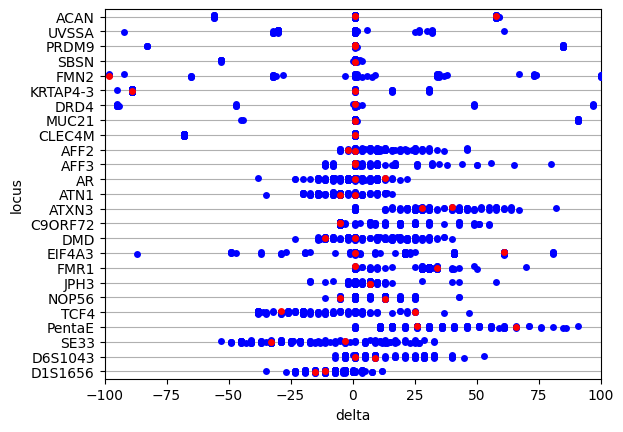

In [333]:
#sample_loci = random.sample(list(data['locus'].unique()), 20)

view = data.set_index('locus').loc[pheno_loci + patho_loci + codis_loci].reset_index()

p = sb.stripplot(data=view[~view['is_HG002']], 
                   color='blue',#'is_HG002',
                   x="delta", y="locus")
p = sb.stripplot(data=view[view['is_HG002']], 
                   color='red',#'is_HG002',
                   x="delta", y="locus")

#plt.legend().remove()
window=100
p.set(xlim=(-window, window))
plt.grid(axis='y')

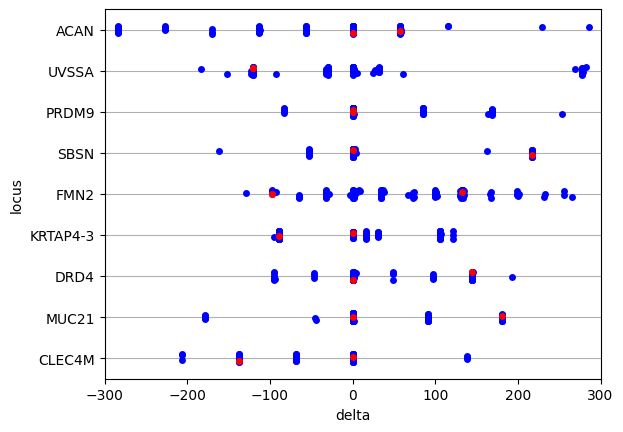

In [334]:
#sample_loci = random.sample(list(data['locus'].unique()), 20)

view = data.set_index('locus').loc[pheno_loci].reset_index()

p = sb.stripplot(data=view[~view['is_HG002']], 
                   color='blue',#'is_HG002',
                   x="delta", y="locus")
p = sb.stripplot(data=view[view['is_HG002']], 
                   color='red',#'is_HG002',
                   x="delta", y="locus")

#plt.legend().remove()
window=300
p.set(xlim=(-window, window))
plt.grid(axis='y')
plt.savefig('vntr.pdf')

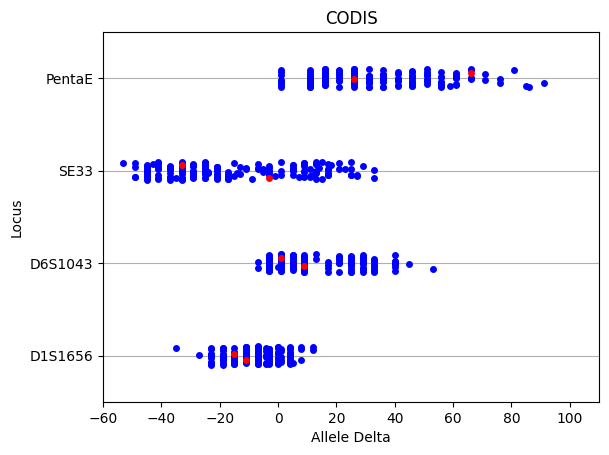

In [342]:
#sample_loci = random.sample(list(data['locus'].unique()), 20)

view = data.set_index('locus').loc[codis_loci].reset_index()

p = sb.stripplot(data=view[~view['is_HG002']], 
                   color='blue',#'is_HG002',
                   x="delta", y="locus")
p = sb.stripplot(data=view[view['is_HG002']], 
                   color='red',#'is_HG002',
                   x="delta", y="locus")

#plt.legend().remove()
window=100
p.set(xlim=(-60, 110), xlabel="Allele Delta", title="CODIS", ylabel="Locus")
plt.grid(axis='y')
plt.savefig('codis.pdf')

In [317]:
data[data['locus'] == 'ATXN3']

locus           hap  length   tier   type  \
chrom start    end                                                   
chr14 92070985 92071080  ATXN3       HG002_1     135  Tier1  Patho   
               92071080  ATXN3       HG002_2     123  Tier1  Patho   
               92071080  ATXN3       HG005_1      96  Tier1  Patho   
               92071080  ATXN3       HG005_2      96  Tier1  Patho   
               92071080  ATXN3     HG00096_1     126  Tier1  Patho   
...                        ...           ...     ...    ...    ...   
               92071080  ATXN3  li:HG00733_2      96  Tier1  Patho   
               92071080  ATXN3  li:NA12878_1     123  Tier1  Patho   
               92071080  ATXN3  li:NA12878_2     126  Tier1  Patho   
               92071080  ATXN3  li:NA24385_1     135  Tier1  Patho   
               92071080  ATXN3  li:NA24385_2     123  Tier1  Patho   

                         motif_length  ref_length  delta  is_HG002  appx copy  
chrom start    end                                                             
chr14 92070985 92071080           3.0         121    -14      True  -4.666667  
               92071080           3.0         121     -2      True  -0.666667  
               92071080           3.0         121     25     False   8.333333  
               92071080           3.0         121     25     False   8.333333  
               92071080           3.0         121     -5     False  -1.666667  
...                               ...         ...    ...       ...        ...  
               92071080           3.0         121     25     False   8.333333  
               92071080           3.0         121     -2     False  -0.666667  
               92071080           3.0         121     -5     False  -1.666667  
               92071080           3.0         121    -14     False  -4.666667  
               92071080           3.0         121     -2     False  -0.666667  

[172 rows x 10 columns]

In [309]:
view[view['tier'].isna()]

,locus,hap,length,tier,type,motif_length,ref_length,delta,is_HG002,appx copy
860,BEAN1,HG002_1,150,None,Patho,5.0,145,-5,True,-1.0
861,BEAN1,HG002_2,105,None,Patho,5.0,145,40,True,8.0
862,BEAN1,HG005_1,160,None,Patho,5.0,145,-15,False,-3.0
863,BEAN1,HG005_2,1119,None,Patho,5.0,145,-974,False,-194.8
864,BEAN1,HG00096_1,145,None,Patho,5.0,145,0,False,0.0
...,...,...,...,...,...,...,...,...,...,...
1027,BEAN1,li:HG00733_2,130,None,Patho,5.0,145,15,False,3.0
1028,BEAN1,li:NA12878_1,140,None,Patho,5.0,145,5,False,1.0
1029,BEAN1,li:NA12878_2,120,None,Patho,5.0,145,25,False,5.0
1030,BEAN1,li:NA24385_1,105,None,Patho,5.0,145,40,False,8.0


In [308]:
view['tier'].value_counts(dropna=False) / 172

Tier1    8.0
Tier2    4.0
None     1.0
Name: tier, dtype: float64

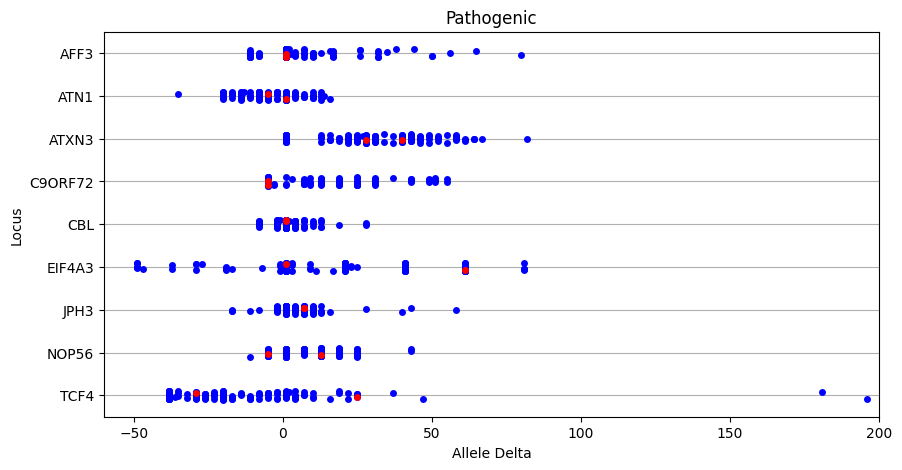

In [384]:
#sample_loci = random.sample(list(data['locus'].unique()), 20)
plt.figure(figsize=(10, 5))
view = data.set_index('locus').loc[patho_loci].reset_index()

p = sb.stripplot(data=view[~view['is_HG002']], 
                   color='blue',#'is_HG002',
                   x="delta", y="locus")
p = sb.stripplot(data=view[view['is_HG002']], 
                   color='red',#'is_HG002',
                   x="delta", y="locus")

#plt.legend().remove()
p.set(xlim=(-60, 200), xlabel="Allele Delta", title="Pathogenic", ylabel="Locus")
#p.set( xlabel="Allele Delta", title="Pathogenic", ylabel="Locus")
plt.grid(axis='y')
plt.savefig('patho.pdf')

In [297]:
view['locus'].unique()

array(['DAB1'], dtype=object)

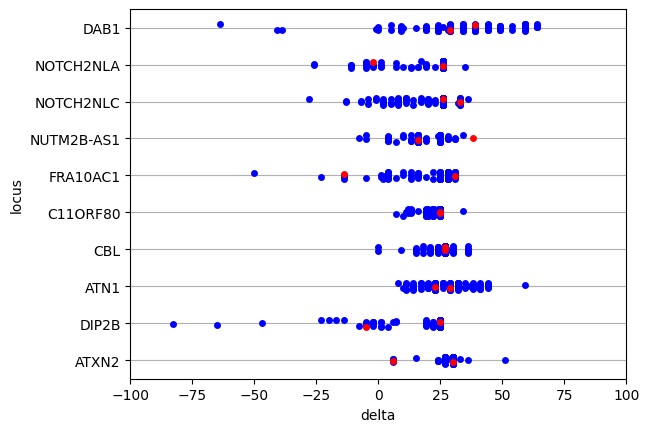

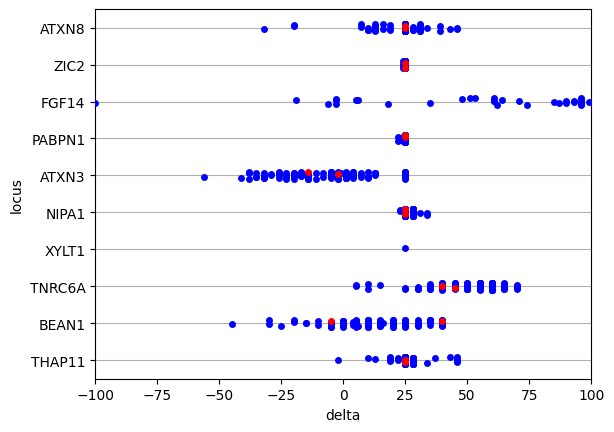

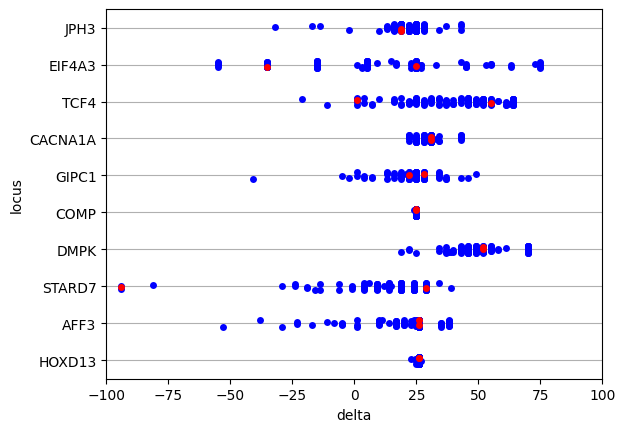

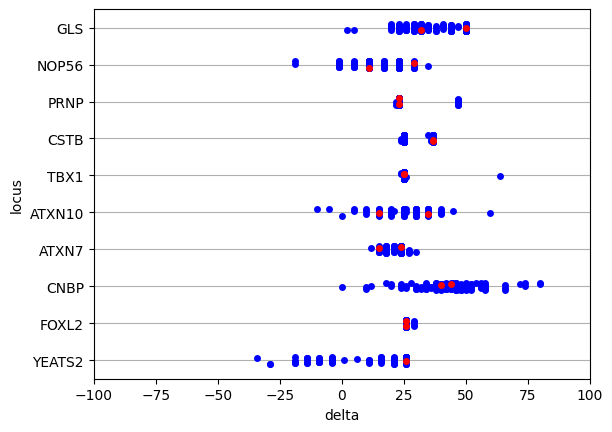

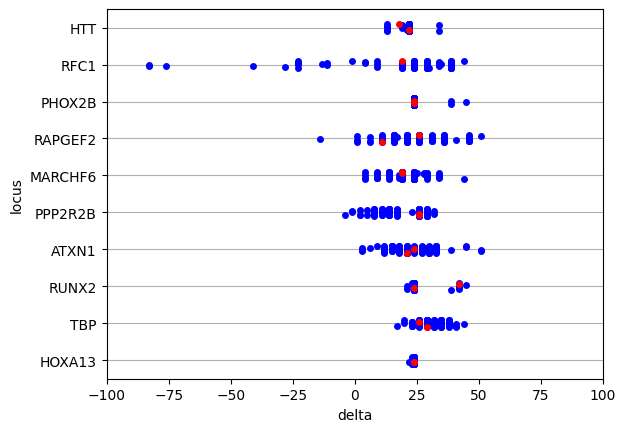

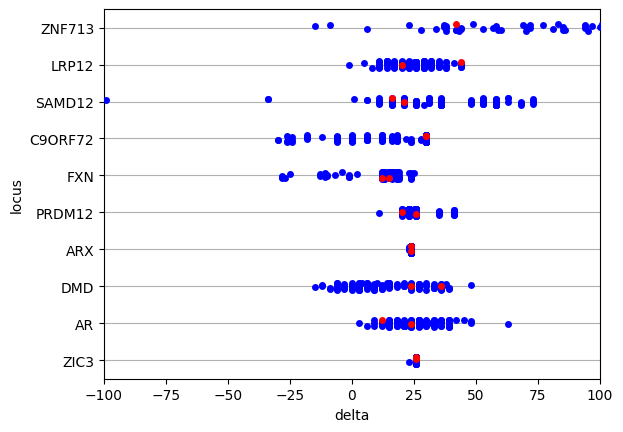

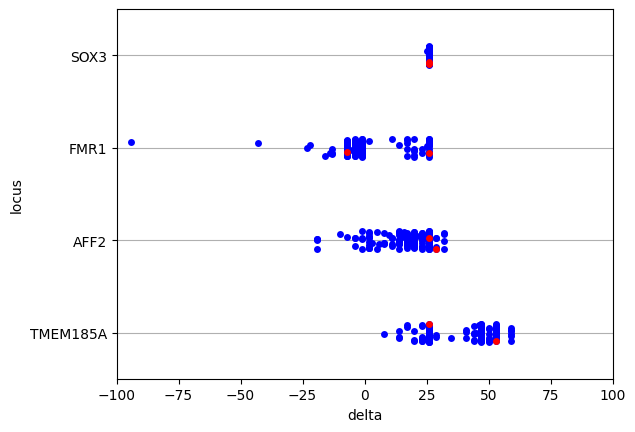

In [298]:
#sample_loci = random.sample(list(data['locus'].unique()), 20)
x = data[data['type'] == 'Patho']['locus'].unique()
for i in range(0, len(x), 10):
    view = data[data['locus'].isin(x[i:i+10])]#data['type'] == 'Patho']#.set_index('locus').loc[patho_loci].reset_index()

    p = sb.stripplot(data=view[~view['is_HG002']], 
                       color='blue',#'is_HG002',
                       x="delta", y="locus")
    p = sb.stripplot(data=view[view['is_HG002']], 
                       color='red',#'is_HG002',
                       x="delta", y="locus")

    #plt.legend().remove()
    window=100
    p.set(xlim=(-window, window))
    plt.grid(axis='y')
    plt.show()


In [253]:

data[data['locus'].isin(patho[patho['Repeat type'] != 'VNTR'].index)
    & ~data['tier'].isna()
    & ~data['motif_length'].isna()][['tier', 'locus', 'motif_length']].drop_duplicates()

tier    locus  motif_length
chrom start     end                                    
chr11 119206264 119206484  Tier1      CBL           3.0
chr12 6936675   6936805    Tier1     ATN1           3.0
      50504976  50505257   Tier1    DIP2B           3.0
      111598797 111599043  Tier1    ATXN2           3.0
chr13 70139383  70139459   Tier1    ATXN8           3.0
      99985421  99985632   Tier1     ZIC2           3.0
      102161544 102161750  Tier1    FGF14           3.0
chr14 23321433  23321542   Tier1   PABPN1           3.0
      92070985  92071080   Tier1    ATXN3           3.0
chr16 17470858  17472830   Tier1    XYLT1           3.0
      67842833  67843011   Tier1   THAP11           3.0
      87604257  87604353   Tier1     JPH3           3.0
chr18 55586153  55586253   Tier1     TCF4           3.0
chr19 13207828  13207928   Tier1  CACNA1A           3.0
      14496016  14496321   Tier1    GIPC1           3.0
      18786002  18786074   Tier1     COMP           3.0
      45770174  45770363   Tier1     DMPK           3.0
chr2  176092710 176093279  Tier1   HOXD13           3.0
      190880842 190880919  Tier1      GLS           3.0
chr20 2652707   2652885    Tier1    NOP56           6.0
chr22 19766695  19766998   Tier1     TBX1           3.0
      45795329  45795448   Tier1   ATXN10           5.0
chr3  63912613  63912751   Tier1    ATXN7           3.0
      129171978 129172783  Tier1     CNBP           4.0
      138946021 138946093  Tier1    FOXL2           3.0
chr4  3074938   3075085    Tier1      HTT           3.0
      41745947  41746316   Tier1   PHOX2B           3.0
chr5  146878696 146878789  Tier1  PPP2R2B           3.0
chr6  16327608  16327748   Tier1    ATXN1           3.0
      45422652  45423000   Tier1    RUNX2           3.0
      170561881 170562047  Tier1      TBP           3.0
chr8  104588910 104589215  Tier1    LRP12           3.0
chr9  27573454  27573570   Tier1  C9ORF72           6.0
      69037236  69037309   Tier1      FXN           3.0
      130681498 130681800  Tier1   PRDM12           3.0
chrX  31284532  31284631   Tier2      DMD           3.0
      67545316  67545443   Tier2       AR           3.0
      137566800 137567014  Tier2     ZIC3           3.0
      140504286 140504449  Tier2     SOX3           3.0
      147911953 147912539  Tier2     FMR1           3.0
      148500571 148501531  Tier2     AFF2           3.0

In [246]:
patho.loc['CLEC4M']

chrom                                                           chr19
start                                                         7765776
end                                                           7766151
Motifs 1            GCTGAAGGCTGCAGTGGGTGAGTTGCCAGAGAAATCCAAGCTGCAG...
Motifs 2                                                          NaN
Repeat type                                                      VNTR
Region                                                     intra-exon
Path. repeats                                                     NaN
Inheritance mode                                                  NaN
Disease                                                           NaN
Name: CLEC4M, dtype: object

In [203]:
view.sort_values(['locus']).drop_duplicates(['locus'])['tier'].value_counts()

Tier1    13
Name: tier, dtype: int64

In [54]:
view = data.set_index(['chrom', 'start', 'end']).join(bench.set_index(['chrom', 'start', 'end']), how='left')

In [55]:
view.head()

locus        hap  length tier repl  vflag  entropy  \
chrom start     end                                                             
chr1  111414853 111415104  OVGP1    HG002_1     252  NaN  NaN    NaN      NaN   
                111415104  OVGP1    HG002_2     183  NaN  NaN    NaN      NaN   
                111415104  OVGP1    HG005_1     252  NaN  NaN    NaN      NaN   
                111415104  OVGP1    HG005_2     252  NaN  NaN    NaN      NaN   
                111415104  OVGP1  HG00096_1     252  NaN  NaN    NaN      NaN   

                           mad  pad  
chrom start     end                  
chr1  111414853 111415104  NaN  NaN  
                111415104  NaN  NaN  
                111415104  NaN  NaN  
                111415104  NaN  NaN  
                111415104  NaN  NaN

In [52]:
data.head()

,locus,chrom,start,end,hap,length
0,PER3,chr1,7829857,7830154,HG002_1,298
1,PER3,chr1,7829857,7830154,HG002_2,298
2,PER3,chr1,7829857,7830154,HG005_1,244
3,PER3,chr1,7829857,7830154,HG005_2,244
4,PER3,chr1,7829857,7830154,HG00096_1,244


In [53]:
bench[(bench['chrom'] == 'chr1') & (bench['start'] == 7829857)]

,chrom,start,end,tier,repl,vflag,entropy,mad,pad
4539,chr1,7829857,7830154,Tier1,TN_TN_TN,14,0.966942,0,0


In [50]:
view[~view['tier'].isna()]

,,,locus,hap,length,tier,repl,vflag,entropy,mad,pad
chrom,start,end,,,,,,,,,


In [354]:
import numpy as np
c = pd.Series([10, 17, 21, 7, 15, 15, 12, 11, 10, 9, 9, 7, 4, 2, 2, 1, 1, 1, 1, 1])

In [355]:
c / c.sum()

0     0.064103
1     0.108974
2     0.134615
3     0.044872
4     0.096154
5     0.096154
6     0.076923
7     0.070513
8     0.064103
9     0.057692
10    0.057692
11    0.044872
12    0.025641
13    0.012821
14    0.012821
15    0.006410
16    0.006410
17    0.006410
18    0.006410
19    0.006410
dtype: float64

In [357]:
15 / 156

0.09615384615384616

In [358]:
4 / 156

0.02564102564102564

In [361]:
data[data['locus'] == 'TCF4'].sort_values('length', ascending=False)

locus        hap  length   tier   type  motif_length  \
chrom start    end                                                             
chr18 55586153 55586253  TCF4  HG00512_1     296  Tier1  Patho           3.0   
               55586253  TCF4  HG00514_2     281  Tier1  Patho           3.0   
               55586253  TCF4     PGP1_1     147  Tier1  Patho           3.0   
               55586253  TCF4  HG03732_2     137  Tier1  Patho           3.0   
               55586253  TCF4  NA24385_2     125  Tier1  Patho           3.0   
...                       ...        ...     ...    ...    ...           ...   
               55586253  TCF4  NA20129_2      62  Tier1  Patho           3.0   
               55586253  TCF4  HG02011_2      62  Tier1  Patho           3.0   
               55586253  TCF4  HG02080_1      62  Tier1  Patho           3.0   
               55586253  TCF4  HG02080_2      62  Tier1  Patho           3.0   
               55586253  TCF4  HG03732_1      62  Tier1  Patho           3.0   

                         span  ref_length  delta  is_HG002  appx copy  
chrom start    end                                                     
chr18 55586153 55586253   100         126    196     False  65.333333  
               55586253   100         126    181     False  60.333333  
               55586253   100         126     47     False  15.666667  
               55586253   100         126     37     False  12.333333  
               55586253   100         126     25     False   8.333333  
...                       ...         ...    ...       ...        ...  
               55586253   100         126    -38     False -12.666667  
               55586253   100         126    -38     False -12.666667  
               55586253   100         126    -38     False -12.666667  
               55586253   100         126    -38     False -12.666667  
               55586253   100         126    -38     False -12.666667  

[172 rows x 11 columns]